In [1]:
import geopandas as gpd
import pandas as pd
import contextily as ctx
import pathlib
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, LineString

# Storm Forecasts & Track
Storm forecasts and historical track will be published for each in-game day.

In [2]:
# Forecasts
day1_forecast = gpd.read_file('https://files.bwsi-remote-sensing.net/data/final/day1/day1_forecasts.geojson')

In [3]:
random_color = lambda: np.random.random(3)

In [4]:
# look at the forecasts
day1_forecast

,prediction,forecastHour,datetime,maxWinds,category,geometry
0,1,12,2021-07-28T08:00:00,70,1,POINT (-69.75497 37.90491)
1,1,24,2021-07-28T20:00:00,75,1,POINT (-70.50738 38.86856)
2,1,36,2021-07-29T08:00:00,85,2,POINT (-71.35866 39.41313)
3,1,48,2021-07-29T20:00:00,85,2,POINT (-71.72152 40.51758)
4,1,60,2021-07-30T08:00:00,100,3,POINT (-71.48969 41.18486)
...,...,...,...,...,...,...
155,20,48,2021-07-29T20:00:00,85,2,POINT (-71.49297 40.27587)
156,20,60,2021-07-30T08:00:00,100,3,POINT (-70.95934 42.12895)
157,20,72,2021-07-30T20:00:00,105,3,POINT (-71.61717 40.70945)
158,20,96,2021-07-31T20:00:00,90,2,POINT (-70.44554 43.65152)


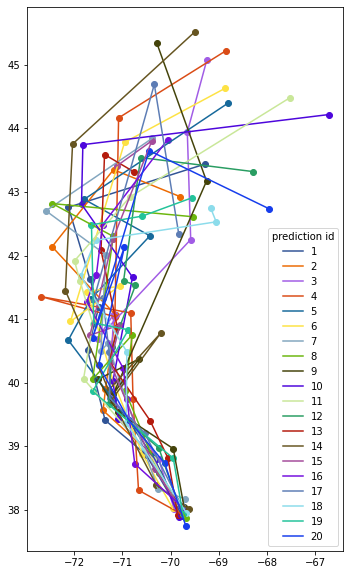

In [5]:
# each forecast report has a number of possible hurricane routes
# they are identified by the prediction column
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for pred_id, pred in day1_forecast.groupby('prediction'):
    c = random_color()
    pred.plot(color=c, ax=ax)
    line_to_plot = LineString(pred.geometry.values)
    ax.plot(line_to_plot.xy[0], line_to_plot.xy[1], color=c, label=f'{pred_id}')
ax.legend(title='prediction id')

<AxesSubplot:>

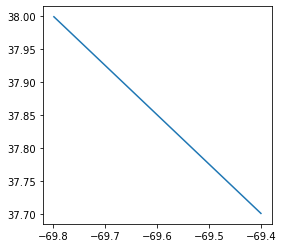

In [6]:
# track shows where the storm actually went in the past
day1_track = gpd.read_file('https://files.bwsi-remote-sensing.net/data/final/day1/day1_track_past.geojson')
day1_track.plot()

# Game Grid
This is the grid that represents the scope of the response, and also the transportation network
It uses the [Military Grid Reference System](https://en.wikipedia.org/wiki/Military_Grid_Reference_System) to divide the world into a grid. There is a unique alphanumeric string that identifies each cell. We are working at the 1km resolution of the grid. See also the [US National Grid](https://www.fgdc.gov/usng/how-to-read-usng) which is nearly identical, except for some [edge-cases](https://www.maptools.com/tutorials/mgrs_usng_diffs).

In [7]:
import networkx as nx # need networkx >= 2.5
import osmnx as ox
import contextily as ctx 
from matplotlib import pyplot as plt
from shapely.geometry import Polygon
import folium
import numpy as np
import geopandas as gpd

In [8]:
# downloading pre-hurricane game grid (pretty big file ~ 111 MB)
!wget https://files.bwsi-remote-sensing.net/data/final/game_grid_2021.geojson

--2021-07-29 16:09:27--  https://files.bwsi-remote-sensing.net/data/final/game_grid_2021.geojson
Resolving files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)... 52.37.91.126, 44.225.198.165, 100.20.1.230, ...
Connecting to files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)|52.37.91.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116721567 (111M)
Saving to: ‘game_grid_2021.geojson.1’

game_grid_2021.geoj 100%[===================>] 111.31M   241MB/s    in 0.5s    

2021-07-29 16:09:27 (241 MB/s) - ‘game_grid_2021.geojson.1’ saved [116721567/116721567]



In [9]:
game_grid = gpd.read_file('game_grid_2021.geojson')

In [10]:
game_grid

,EASTING,NORTHING,kmSQ_ID,GZD,Shape_Leng,MGRS,MGRS_10km,transport_score,geometry
0,596000mE,4984000mN,WQ,18T,400000.000000,18TWQ9684,18TWQ98,1,"POLYGON ((-73.76921 45.00282, -73.78190 45.002..."
1,597000mE,4984000mN,WQ,18T,400000.000000,18TWQ9784,18TWQ98,1,"POLYGON ((-73.75653 45.00268, -73.76921 45.002..."
2,598000mE,4984000mN,WQ,18T,400000.000000,18TWQ9884,18TWQ98,1,"POLYGON ((-73.74384 45.00254, -73.75653 45.002..."
3,599000mE,4984000mN,WQ,18T,400000.000000,18TWQ9984,18TWQ98,1,"POLYGON ((-73.73116 45.00240, -73.74384 45.002..."
4,579000mE,4983000mN,WQ,18T,400000.000000,18TWQ7983,18TWQ78,1,"POLYGON ((-73.98504 44.99594, -73.99773 44.996..."
...,...,...,...,...,...,...,...,...,...
232562,282000mE,4558000mN,BF,19T,0.041828,19TBF8258,19TBF85,1,"POLYGON ((-71.58574 41.14431, -71.59765 41.144..."
232563,283000mE,4558000mN,BF,19T,0.041828,19TBF8358,19TBF85,1,"POLYGON ((-71.57384 41.14458, -71.58574 41.144..."
232564,284000mE,4558000mN,BF,19T,0.041828,19TBF8458,19TBF85,1,"POLYGON ((-71.56193 41.14484, -71.57384 41.144..."
232565,285000mE,4558000mN,BF,19T,0.041828,19TBF8558,19TBF85,1,"POLYGON ((-71.55003 41.14511, -71.56193 41.144..."


<AxesSubplot:>

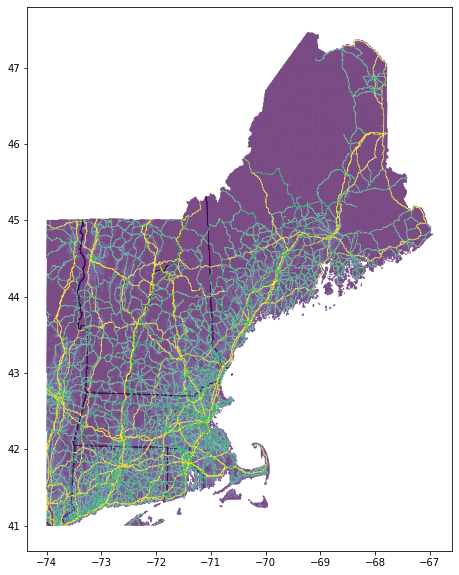

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
game_grid.plot(column='transport_score', ax=ax)

In [12]:
w,s,e,n = game_grid.total_bounds
print(w,s,e,n)

-74.0062751207002 40.995556258214776 -66.93832921282291 47.46624330268622


In [13]:
import pandas as pd
hospitals_url = 'Hospitals.csv'
hospitals_df = pd.read_csv(hospitals_url)

In [14]:
hospitals_df = hospitals_df.fillna('')
hospitals_df

,X,Y,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,...,VAL_DATE,WEBSITE,STATE_ID,ALT_NAME,ST_FIPS,OWNER,TTL_STAFF,BEDS,TRAUMA,HELIPAD
0,-94.945477,29.747620,8497,76777520,HOUSTON METHODIST SAN JACINTO HOSPITAL ALEXAND...,1700 JAMES BOWIE DRIVE,BAYTOWN,TX,77520,NOT AVAILABLE,...,2017-12-18T00:00:00.000Z,http://www.houstonmethodist.org/locations/san-...,NOT AVAILABLE,NOT AVAILABLE,48.0,NON-PROFIT,-999.0,182.0,NOT AVAILABLE,Y
1,-82.881843,40.027143,8498,129043230,"WOODS AT PARKSIDE,THE",349 OLDE RIDENOUR ROAD,COLUMBUS,OH,43230,NOT AVAILABLE,...,2018-04-26T00:00:00.000Z,http://www.thewoodsatparkside.com/,1815,NOT AVAILABLE,39.0,PROPRIETARY,-999.0,50.0,NOT AVAILABLE,NOT AVAILABLE
2,-84.168027,39.774242,8499,130045404,DAYTON CHILDREN'S HOSPITAL,ONE CHILDRENS PLAZA,DAYTON,OH,45404,NOT AVAILABLE,...,2018-04-26T00:00:00.000Z,http://www.childrensdayton.org/cms/home/index....,1411,NOT AVAILABLE,39.0,NON-PROFIT,-999.0,155.0,PEDIATRIC LEVEL II,Y
3,-80.632972,41.005169,8500,128844512,VIBRA HOSPITAL OF MAHONING VALLEY,8049 SOUTH AVENUE,BOARDMAN,OH,44512,NOT AVAILABLE,...,2018-04-26T00:00:00.000Z,http://www.mahoningvalleyhospital.com/,1428,MAHONING VALLEY HOSPITAL BOARDMAN CAMPUS,39.0,PROPRIETARY,-999.0,45.0,NOT AVAILABLE,NOT AVAILABLE
4,-84.199398,39.747740,8501,129845417,HAVEN BEHAVIORAL SENIOR CARE OF DAYTON,"ONE ELIZABETH PLACE,E3 SUITE A",DAYTON,OH,45417,NOT AVAILABLE,...,2018-04-26T00:00:00.000Z,https://dayton.havenbehavioral.com/,1506,NOT AVAILABLE,39.0,PROPRIETARY,-999.0,32.0,NOT AVAILABLE,NOT AVAILABLE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7565,-80.701221,40.372434,8492,128243953,LIFE LINE HOSPITAL,200 SCHOOL STREET,WINTERSVILLE,OH,43953,NOT AVAILABLE,...,2018-04-26T00:00:00.000Z,http://www.llhospital.com/,1493,NOT AVAILABLE,39.0,PROPRIETARY,-999.0,36.0,NOT AVAILABLE,NOT AVAILABLE
7566,-81.336345,40.401257,8493,127744621,"TEN LAKES CENTER, LLC","819 NORTH FIRST STREET,3RD FLOOR",DENNISON,OH,44621,NOT AVAILABLE,...,2018-04-26T00:00:00.000Z,http://www.tenlakescenter.com/,1469,NOT AVAILABLE,39.0,PROPRIETARY,-999.0,16.0,NOT AVAILABLE,NOT AVAILABLE
7567,-84.294586,39.331523,8494,128345040,LINDNER CENTER OF HOPE,4075 OLD WESTERN ROW ROAD,MASON,OH,45040,NOT AVAILABLE,...,2018-04-26T00:00:00.000Z,http://lindnercenterofhope.org/,1481,NOT AVAILABLE,39.0,NON-PROFIT,-999.0,34.0,NOT AVAILABLE,NOT AVAILABLE
7568,-97.283341,29.112615,8495,13879022,CUERO COMMUNITY HOSPITAL,2550 NORTH ESPLANADE STREET,CUERO,TX,79022,NOT AVAILABLE,...,2017-12-18T00:00:00.000Z,http://www.cuerohosp.org,NOT AVAILABLE,NOT AVAILABLE,48.0,GOVERNMENT - DISTRICT/AUTHORITY,-999.0,49.0,LEVEL IV,Y


In [15]:
hospitals_df = hospitals_df.loc[(hospitals_df['X']>= -74.0062751207002) & (hospitals_df['X']<= -66.93832921282291) & (hospitals_df['Y'] >= 40.995556258214776) & (hospitals_df['Y'] <= 47.46624330268622)]
hospitals_df = hospitals_df.reset_index()
hospitals_df

,index,X,Y,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,...,VAL_DATE,WEBSITE,STATE_ID,ALT_NAME,ST_FIPS,OWNER,TTL_STAFF,BEDS,TRAUMA,HELIPAD
0,97,-72.740616,41.701686,8594,3606111,VA MEDICAL CENTER - NEWINGTON CAMPUS,555 WILLARD AVE,NEWINGTON,CT,6111,...,2018-05-15T00:00:00.000Z,http://www.connecticut.va.gov/,NOT AVAILABLE,NOT AVAILABLE,9.0,GOVERNMENT - FEDERAL,-999.0,-999.0,NOT AVAILABLE,N
1,103,-71.053936,42.063022,8601,6002401,VA MEDICAL CENTER - BROCKTON DIVISION,940 BELMONT ST,BROCKTON,MA,2401,...,2018-05-15T00:00:00.000Z,http://www.boston.va.gov/,NOT AVAILABLE,NOT AVAILABLE,25.0,GOVERNMENT - FEDERAL,-999.0,-999.0,NOT AVAILABLE,N
2,104,-72.682440,42.349531,8602,6901062,VA CENTRAL WESTERN MASSACHUSETTS HEALTHCARE SY...,421 N MAIN ST,NORTHAMPTON,MA,1062,...,2018-05-15T00:00:00.000Z,http://www.centralwesternmass.va.gov/,NOT AVAILABLE,NOT AVAILABLE,25.0,GOVERNMENT - FEDERAL,-999.0,-999.0,NOT AVAILABLE,N
3,105,-71.171698,42.274627,8603,6802132,VA MEDICAL CENTER - WEST ROXBURY DIVISION,1400 VFW PKY,WEST ROXBURY,MA,2132,...,2018-05-15T00:00:00.000Z,http://www.boston.va.gov/,NOT AVAILABLE,NOT AVAILABLE,25.0,GOVERNMENT - FEDERAL,-999.0,-999.0,NOT AVAILABLE,N
4,115,-71.440867,43.012358,8613,9103104,VA MEDICAL CENTER - MANCHESTER,718 SMYTH RD,MANCHESTER,NH,3104,...,2018-05-15T00:00:00.000Z,http://www.manchester.va.gov/,NOT AVAILABLE,NOT AVAILABLE,33.0,GOVERNMENT - FEDERAL,-999.0,-999.0,NOT AVAILABLE,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,6776,-72.009558,44.445787,7703,905819,NORTHEASTERN VERMONT REGIONAL HOSPITAL,1315 HOSPITAL DR,ST. JOHNSBURY,VT,5819,...,2018-01-19T00:00:00.000Z,http://www.nvrh.org,E23931,NOT AVAILABLE,50.0,NON-PROFIT,-999.0,25.0,NOT AVAILABLE,Y
342,6777,-71.480809,44.904447,7704,2503576,UPPER CONNECTICUT VALLEY HOSPITAL,181 CORLISS LANE,COLEBROOK,NH,3576,...,2018-02-16T00:00:00.000Z,http://www.ucvh.org,NOT AVAILABLE,NOT AVAILABLE,33.0,NON-PROFIT,-999.0,16.0,NOT AVAILABLE,NOT AVAILABLE
343,6778,-71.554340,44.486230,7705,2703584,WEEKS MEDICAL CENTER,173 MIDDLE STREET,LANCASTER,NH,3584,...,2018-02-16T00:00:00.000Z,http://www.weeksmedical.org,NOT AVAILABLE,NOT AVAILABLE,33.0,NON-PROFIT,-999.0,25.0,NOT AVAILABLE,NOT AVAILABLE
344,6840,-73.803656,42.655968,7767,112208,ST. PETER'S HOSPITAL,315 S MANNING BLVD,ALBANY,NY,12208,...,2017-12-22T00:00:00.000Z,http://www.sphcs.org,0101004H,NOT AVAILABLE,36.0,NON-PROFIT,-999.0,442.0,NOT AVAILABLE,NOT AVAILABLE
